In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os.path
from scipy.fftpack import fft
import seaborn as sns; sns.set()

In [2]:
data_dir = Path('../ADL_Dataset/HMP_Dataset_original/HMP_Dataset/Train')

filepath = list(data_dir.glob(r'**/*.txt'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

filepaths = pd.Series(filepath, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

data_df = pd.concat([filepaths, labels], axis=1)
data_df = data_df.sample(frac=1).reset_index(drop = True)


data_df

,Filepath,Label
0,..\ADL_Dataset\HMP_Dataset_original\HMP_Datase...,Walk
1,..\ADL_Dataset\HMP_Dataset_original\HMP_Datase...,Drink_glass
2,..\ADL_Dataset\HMP_Dataset_original\HMP_Datase...,Standup_chair
3,..\ADL_Dataset\HMP_Dataset_original\HMP_Datase...,Standup_chair
4,..\ADL_Dataset\HMP_Dataset_original\HMP_Datase...,Sitdown_chair
...,...,...
834,..\ADL_Dataset\HMP_Dataset_original\HMP_Datase...,Standup_chair
835,..\ADL_Dataset\HMP_Dataset_original\HMP_Datase...,Descend_stairs
836,..\ADL_Dataset\HMP_Dataset_original\HMP_Datase...,Pour_water
837,..\ADL_Dataset\HMP_Dataset_original\HMP_Datase...,Sitdown_chair


In [3]:
data_df = data_df.sort_values(by=['Label'])
data_df=data_df.reset_index().drop(columns=['index'])

In [4]:
data_df

,Filepath,Label
0,..\ADL_Dataset\HMP_Dataset_original\HMP_Datase...,Brush_teeth
1,..\ADL_Dataset\HMP_Dataset_original\HMP_Datase...,Brush_teeth
2,..\ADL_Dataset\HMP_Dataset_original\HMP_Datase...,Brush_teeth
3,..\ADL_Dataset\HMP_Dataset_original\HMP_Datase...,Brush_teeth
4,..\ADL_Dataset\HMP_Dataset_original\HMP_Datase...,Brush_teeth
...,...,...
834,..\ADL_Dataset\HMP_Dataset_original\HMP_Datase...,Walk
835,..\ADL_Dataset\HMP_Dataset_original\HMP_Datase...,Walk
836,..\ADL_Dataset\HMP_Dataset_original\HMP_Datase...,Walk
837,..\ADL_Dataset\HMP_Dataset_original\HMP_Datase...,Walk


In [4]:
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
data_df['Label']= label_encoder.fit_transform(data_df['Label'])

In [5]:
def load_data(df):
    Y = list()
    group =list()
    for i in range(df['Filepath'].shape[0]):
        frame = []
        data = np.loadtxt(df['Filepath'][i])
        x = data[:,0]
        x = x-x.mean()
        x = fft(x,n=4000)
        #x = x[0:400]
        y = data[:,1]
        y = y-y.mean()
        y = fft(y,n=4000)
        #y = y[0:400]
        z = data[:,2]
        z = z-z.mean()
        z = fft(z,n=4000)
        #z = z[0:400]
        frame.append(x)
        frame.append(y)
        frame.append(z)
        group.append(np.hstack(frame))
        Y.append(df['Label'][i])
    X = np.vstack(group)
    Y = np.vstack(Y)
    
    return np.real(X), Y


In [6]:
X,Y = load_data(data_df)

In [35]:
from sklearn.neighbors import LocalOutlierFactor

In [36]:
outlier_scores = LocalOutlierFactor(contamination=0.001428).fit_predict(X)
outlying_digits = X[outlier_scores == -1]
outlying_digits.shape

(2, 12000)

In [7]:
from imblearn.over_sampling import SMOTE

In [8]:
sm = SMOTE(k_neighbors=5,random_state=42)
X_res, y_res = sm.fit_resample(X, Y)

In [9]:
from sklearn.manifold import TSNE

In [10]:
# Perform t-SNE: Digits
tsne = TSNE(n_components=2, verbose=1, perplexity=7, n_iter=3000000)
tsne_results = tsne.fit_transform(X_res)

c:\Users\vongv\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\vongv\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 22 nearest neighbors...
[t-SNE] Indexed 1326 samples in 0.038s...
[t-SNE] Computed neighbors for 1326 samples in 1.836s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1326
[t-SNE] Computed conditional probabilities for sample 1326 / 1326
[t-SNE] Mean sigma: 2340.075051
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.727264
[t-SNE] KL divergence after 10850 iterations: 0.671495


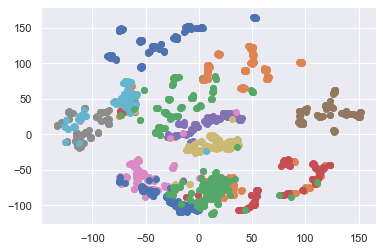

In [12]:
for i in range(13):
    plt.scatter(
        tsne_results[y_res == i, 0], tsne_results[y_res == i, 1],
        
    )


In [13]:
from sklearn.cluster import KMeans


In [16]:
model = KMeans(n_clusters = 13, init = "k-means++",  max_iter=10)
label = model.fit_predict(tsne_results)

589017.0


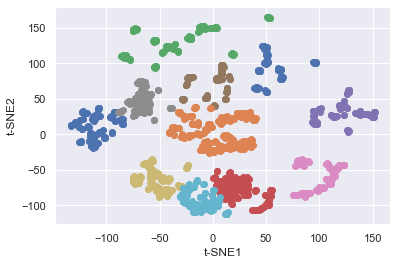

In [17]:

print(model.inertia_)
plt.figure()
uniq = np.unique(label)
for i in uniq:
  plt.scatter(tsne_results[label == i , 0] , tsne_results[label == i , 1] , label = i)
plt.xlabel([])
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_res, label)

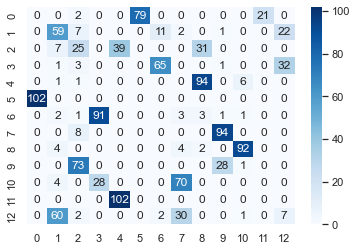

In [21]:
import seaborn as sns; sns.set()

ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [22]:
from sklearn.metrics.cluster import homogeneity_completeness_v_measure
homogeneity_score, completeness_score, v_measure =homogeneity_completeness_v_measure(y_res.reshape(-1), label)
print("homogeneity score", homogeneity_score*100)
print("completeness score", completeness_score*100)

homogeneity score 73.84494632996594
completeness score 75.73973930896281


## PCA

In [23]:
from sklearn.decomposition import PCA

In [50]:
pca = PCA(n_components=200)
pca.fit(X_res)
exp_variance=pca.explained_variance_ratio_

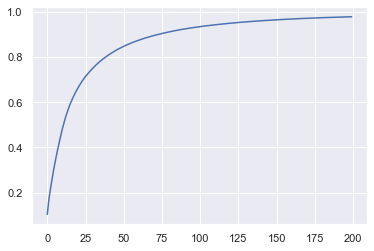

In [55]:
cum_exp_variance = np.cumsum(exp_variance)

fig, ax = plt.subplots()
ax.plot(cum_exp_variance)


In [24]:
pca = PCA(n_components=2)
pca.fit(X_res)
X_reduce = pca.fit_transform(X_res)

In [25]:
pca.explained_variance_ratio_

array([0.10330412, 0.06383316])

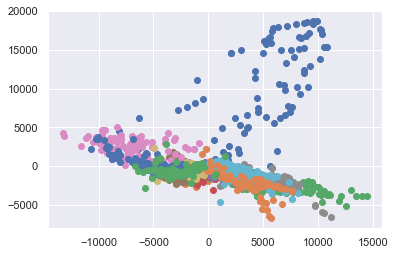

In [26]:
for i in range(13):
    plt.scatter(
        X_reduce[y_res == i, 0], X_reduce[y_res == i, 1],
        
    )


In [27]:
model = KMeans(n_clusters = 13, init = "k-means++",  max_iter=10,random_state=108)
label = model.fit_predict(X_reduce)

2082736148.5631251


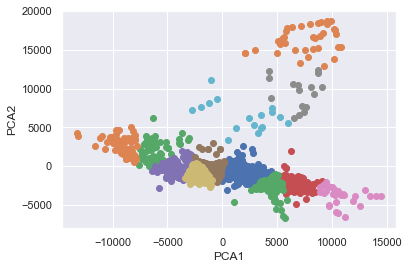

In [28]:

print(model.inertia_)
plt.figure()
uniq = np.unique(label)
for i in uniq:
  plt.scatter(X_reduce[label == i , 0] , X_reduce[label == i , 1] , label = i)
plt.xlabel([])
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

In [29]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_res, label)

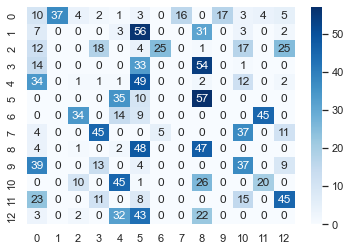

In [30]:
import seaborn as sns; sns.set()

ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [31]:
from sklearn.metrics.cluster import homogeneity_completeness_v_measure
homogeneity_score, completeness_score, v_measure =homogeneity_completeness_v_measure(y_res.reshape(-1), label)
print("homogeneity score", homogeneity_score*100)
print("completeness score", completeness_score*100)

homogeneity score 38.934165660440044
completeness score 43.71931745280752


In [57]:
pca = PCA(n_components=200)
pca.fit(X_res)
X_reduce = pca.transform(X_res)

In [58]:
model = KMeans(n_clusters = 13, init = "k-means++",  max_iter=10)
label = model.fit_predict(X_reduce)

In [59]:
np.sum(pca.explained_variance_ratio_)*100

97.86513453181904

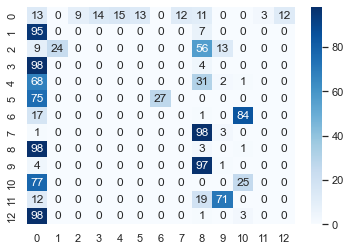

In [60]:

cm = confusion_matrix(y_res, label)
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [61]:
from sklearn.metrics.cluster import homogeneity_completeness_v_measure
homogeneity_score, completeness_score, v_measure =homogeneity_completeness_v_measure(y_res.reshape(-1), label)
print("homogeneity score", homogeneity_score*100)
print("completeness score", completeness_score*100)

homogeneity score 35.94601669667589
completeness score 60.897636009503465


### UMAP

In [37]:
import umap


In [38]:
X_reduce = umap.UMAP(
    n_neighbors=10,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(X_res)

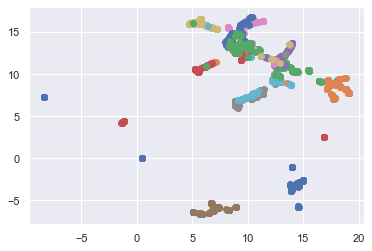

In [39]:
for i in range(13):
    plt.scatter(
        X_reduce[y_res == i, 0], X_reduce[y_res == i, 1],
        
    )


In [40]:
model = KMeans(n_clusters = 13, init = "random",  max_iter=10,random_state=71)
label = model.fit_predict(X_reduce)

1899.984619140625


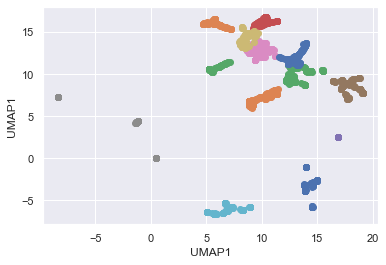

In [41]:
print(model.inertia_)
plt.figure()
uniq = np.unique(label)
for i in uniq:
  plt.scatter(X_reduce[label == i , 0] , X_reduce[label == i , 1] , label = i)
plt.xlabel([])
plt.xlabel('UMAP1')
plt.ylabel('UMAP1')
plt.show()

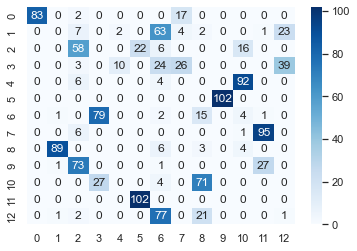

In [42]:
cm = confusion_matrix(y_res, label)
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [43]:
from sklearn.metrics.cluster import homogeneity_completeness_v_measure
homogeneity_score, completeness_score, v_measure =homogeneity_completeness_v_measure(y_res.reshape(-1), label)
print("homogeneity score", homogeneity_score*100)
print("completeness score", completeness_score*100)

homogeneity score 71.08561383642491
completeness score 74.16104706430843
